In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

## Boilerplate needed for notebooks

In [2]:
run_dir = "../results/Transop_Laplacian_KL2e-5_small-init_no-wd_12-21-2022_14-58-23/"
current_checkpoint = 1999
device_idx = [0]

In [7]:
import sys
import os 
import math
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
from omegaconf import OmegaConf
import omegaconf

from eval.utils import encode_features
from model.model import Model
from model.config import ModelConfig
from experiment import ExperimentConfig
from dataloader.contrastive_dataloader import get_dataloader
from dataloader.utils import get_unaugmented_dataloader

# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(run_dir + ".hydra/config.yaml")
cfg.model_cfg.backbone_cfg.load_backbone = None
cfg.model_cfg.header_cfg.transop_header_cfg.fine_tune_iter = 0
# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, cfg.train_dataloader_cfg.dataset_cfg.dataset_name, device_idx)
state_dict = torch.load(run_dir + f"checkpoints/checkpoint_epoch{current_checkpoint}.pt")
model.load_state_dict(state_dict['model_state'])
# Manually override directory for dataloaders
cfg.train_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
cfg.train_dataloader_cfg.batch_size = 16
cfg.eval_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
# Load dataloaders
train_dataset, train_dataloader = get_dataloader(cfg.train_dataloader_cfg)
eval_dataset, eval_dataloader = get_dataloader(cfg.eval_dataloader_cfg)
unaugmented_train_dataloader = get_unaugmented_dataloader(train_dataloader)
# Get encoding of entire dataset
train_eval_input = encode_features(model, unaugmented_train_dataloader, default_device)
# Load transport operators
psi = model.contrastive_header.transop_header.transop.get_psi()

Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
coeff_list = []
z0 = []
z1 = []
z1_hat = []

for idx, batch in enumerate(train_dataloader):
    x_list = list(batch[0])
    # Tensor of input images of shape [B x V x H x W x C]
    x_gpu = torch.stack([x.to(default_device) for x in x_list]).transpose(0, 1)
    x_idx = torch.Tensor([int(idx) for idx in batch[2]])

    model_output = model(x_gpu, x_idx, 0)
    header_out = model_output.header_output
    coeff_list.append(header_out.distribution_data.samples.detach().cpu().numpy())
    
    z0.append(header_out.header_dict["transop_z0"].detach().cpu().numpy())
    z1.append(header_out.header_dict["transop_z1"].detach().cpu().numpy())
    z1_hat.append(header_out.header_dict["transop_z1hat"].detach().cpu().numpy())

    #loss_metadata, total_loss = model.compute_loss(model_output)
    #if idx == 50:
    #    break
z0 = np.concatenate(z0)
z1 = np.concatenate(z1)
z1_hat = np.concatenate(z1_hat)

/home/kion/manifold-contrastive/src/model/manifold/transop.py:32: UserWarning: An output with one or more elements was resized since it had shape [128, 64, 64], which does not match the required output shape [1, 128, 64, 64]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/Resize.cpp:17.)
  out = torch.matrix_exp(T) @ x


0.9999814


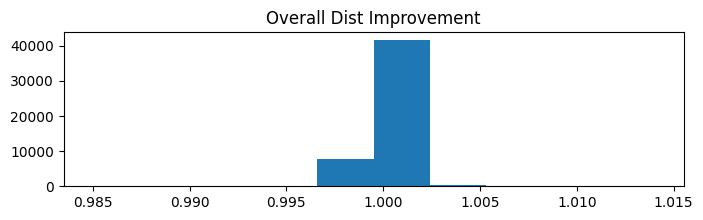

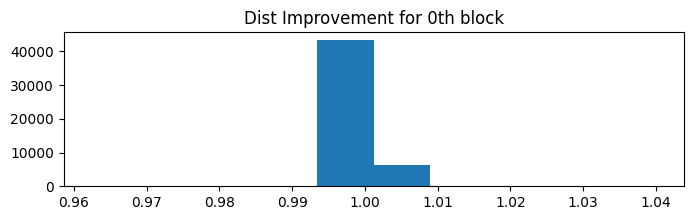

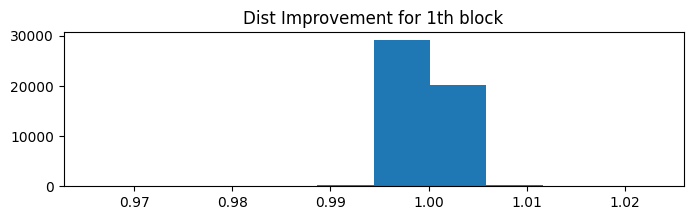

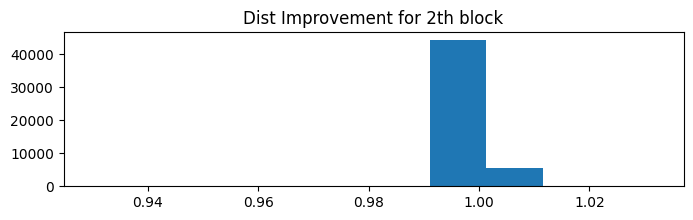

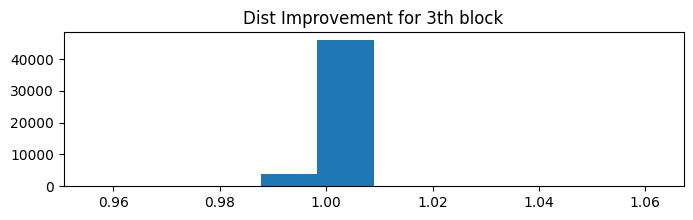

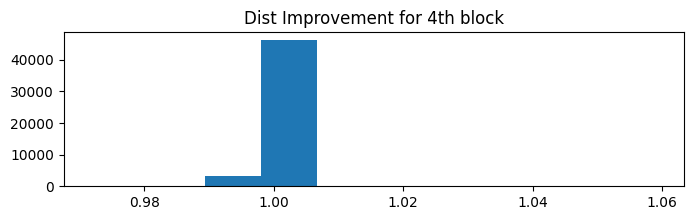

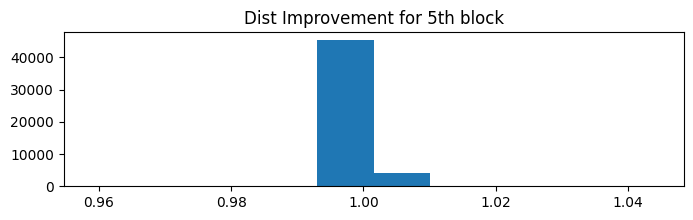

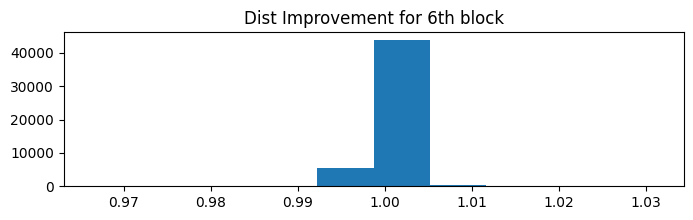

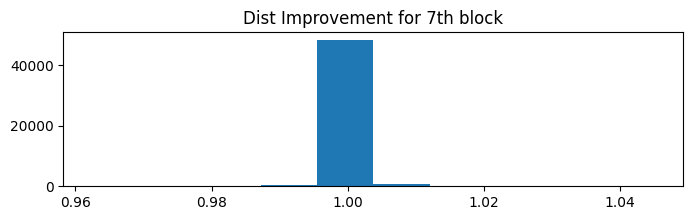

In [28]:
base_distance = ((z0 - z1)**2).sum(axis=-1)
to_distance = ((z1_hat - z1)**2).sum(axis=-1)

plt.figure(figsize=(8,2))
plt.hist((to_distance / (base_distance+ 1e-6)))
print((to_distance / (base_distance+ 1e-6)).mean())
plt.title("Overall Dist Improvement")

if cfg.model_cfg.header_cfg.transop_header_cfg.enable_splicing:
    splice_dim = cfg.model_cfg.header_cfg.transop_header_cfg.splice_dim
    for i in range(z0.shape[-1] // splice_dim):
        plt.figure(figsize=(8,2))
        base_distance = ((z0[..., i*splice_dim:(i+1)*splice_dim] - z1[..., i*splice_dim:(i+1)*splice_dim])**2).sum(axis=-1)
        to_distance = ((z1_hat[..., i*splice_dim:(i+1)*splice_dim] - z1[..., i*splice_dim:(i+1)*splice_dim])**2).sum(axis=-1)
        plt.hist((to_distance / (base_distance+ 1e-6)))
        plt.title(f"Dist Improvement for {i}th block")

[ 9 11 92 19 41 72 80 53 45 44 66  4 88  6 91 10 47 89 17 64 35  5 24  1
 14 48 84 25 60 40 56 86 79 12 67 49  2 68 78 22  3 31  0 81 33 37 61 97
 98 55 30 93 29 50 95 42 71 83 62 94 99 69 73 59 39 18 13 58 34 15 36 38
 96 77 26 70 63  8 16 74 52 75 46 65 23 21 28 82  7 54 32 57 76 27 20 51
 43 90 85 87]


Text(0.5, 1.0, 'Transport Operator Index')

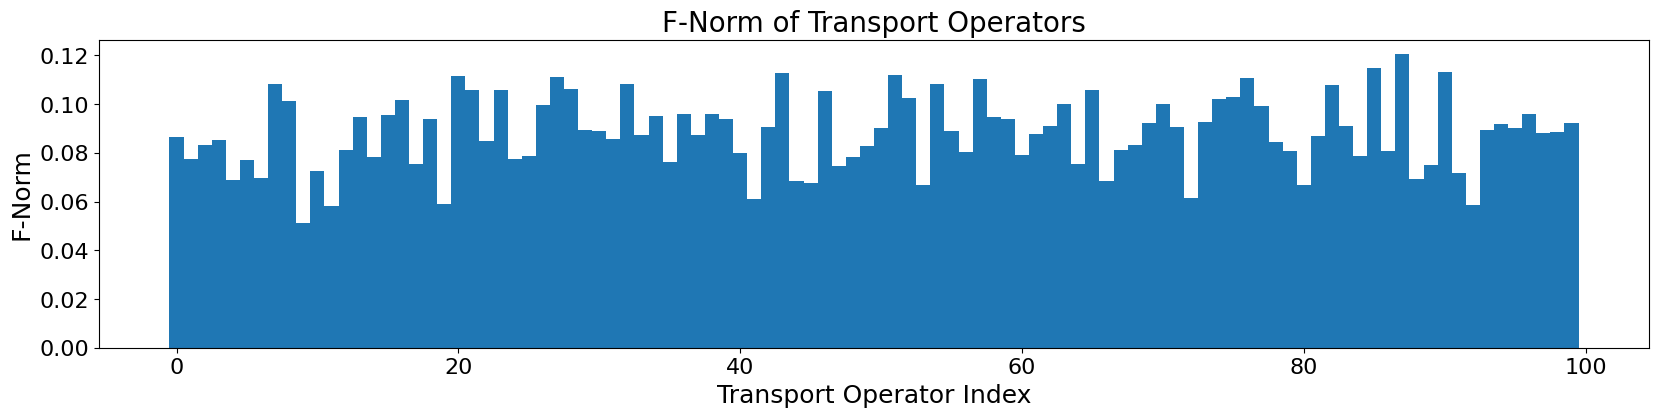

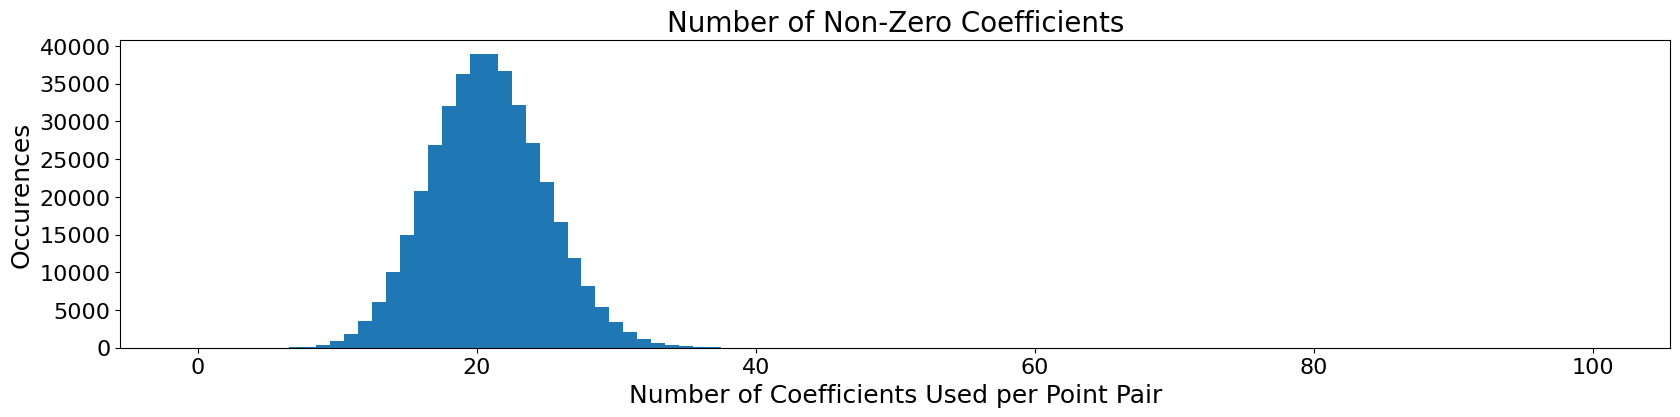

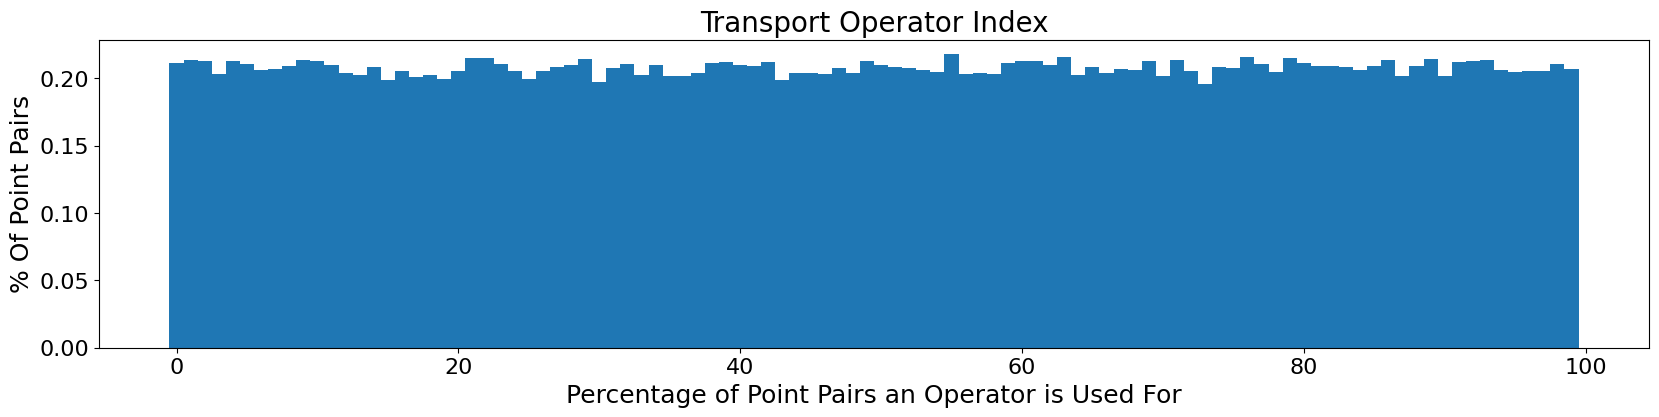

In [14]:
mini_coeff_list = np.concatenate(coeff_list)
count_nz = np.zeros(len(psi) + 1, dtype=int)
coeff_nz = np.count_nonzero(mini_coeff_list, axis=0)
total_nz = np.count_nonzero(mini_coeff_list, axis=1)
for z in range(len(total_nz)):
    count_nz[total_nz[z]] += 1
number_operator_uses = np.count_nonzero(mini_coeff_list, axis=0) / len(mini_coeff_list)

transop_norms = ((psi.reshape(len(psi), -1))**2).sum(dim=-1).detach().cpu().numpy()
print(np.argsort(transop_norms))
fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), transop_norms, width=1)
plt.xlabel("Transport Operator Index", fontsize=18)
plt.ylabel("F-Norm", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("F-Norm of Transport Operators", fontsize=20)

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms) + 1), count_nz, width=1)
plt.xlabel("Number of Coefficients Used per Point Pair", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Number of Non-Zero Coefficients", fontsize=20)

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), number_operator_uses, width=1)
plt.xlabel("Percentage of Point Pairs an Operator is Used For", fontsize=18)
plt.ylabel("% Of Point Pairs", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Transport Operator Index", fontsize=20)

In [1]:
import torchvision
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

default_device = torch.device("cuda:1")
save = torch.load("../results/transop_vi_mae_temp-warmup-gamma_1e-3.pt")
#psi = save['transOp']['psi'].to('cuda:1')
psi = save['psi'][-1].to(default_device)
z = save['z0'][0].to(default_device)

/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '../results/transop_vi_mae_temp-warmup-gamma_1e-3.pt'

In [2]:
import time
time_taken = {}
dim = [32, 64, 128, 512, 2048]

for psi_dim in dim:
    x0 = torch.randn((16, psi_dim, 1), device=default_device)
    x1 = torch.randn((16, psi_dim, 1), device=default_device)
    time_taken[psi_dim] = []
    for i in range(20):
        pre_time = time.time()
        psi = torch.randn((200, psi_dim, psi_dim), device=default_device, requires_grad=True)
        c = torch.randn((16, 200), device=default_device)
        c = c / torch.linalg.norm(c)
        T = torch.matrix_exp(torch.einsum("bs,smn->bmn", c, psi))
        torch.nn.functional.mse_loss(T @ x0, x1).backward()
        if i >= 3:
            time_taken[psi_dim].append(time.time() - pre_time)

RuntimeError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 1; 9.78 GiB total capacity; 6.03 GiB already allocated; 659.81 MiB free; 6.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Text(0.5, 0, 'Dimension of Psi')

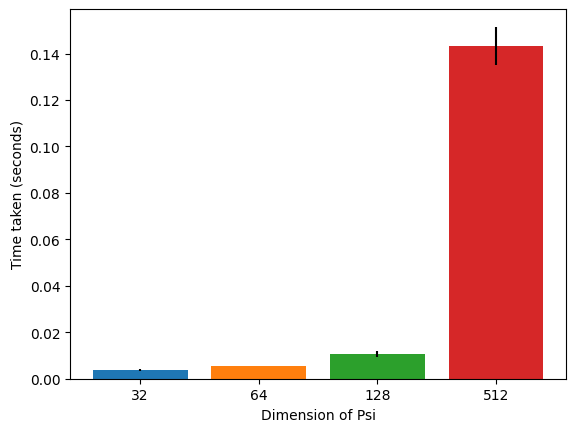

In [5]:
plt.figure()
for idx, psi_dim in enumerate(dim):
    plt.bar(idx, np.mean(time_taken[psi_dim]), yerr=np.std(time_taken[psi_dim]))
plt.xticks(np.arange(len(dim)), dim)
plt.ylabel("Time taken (seconds)")
plt.xlabel("Dimension of Psi")


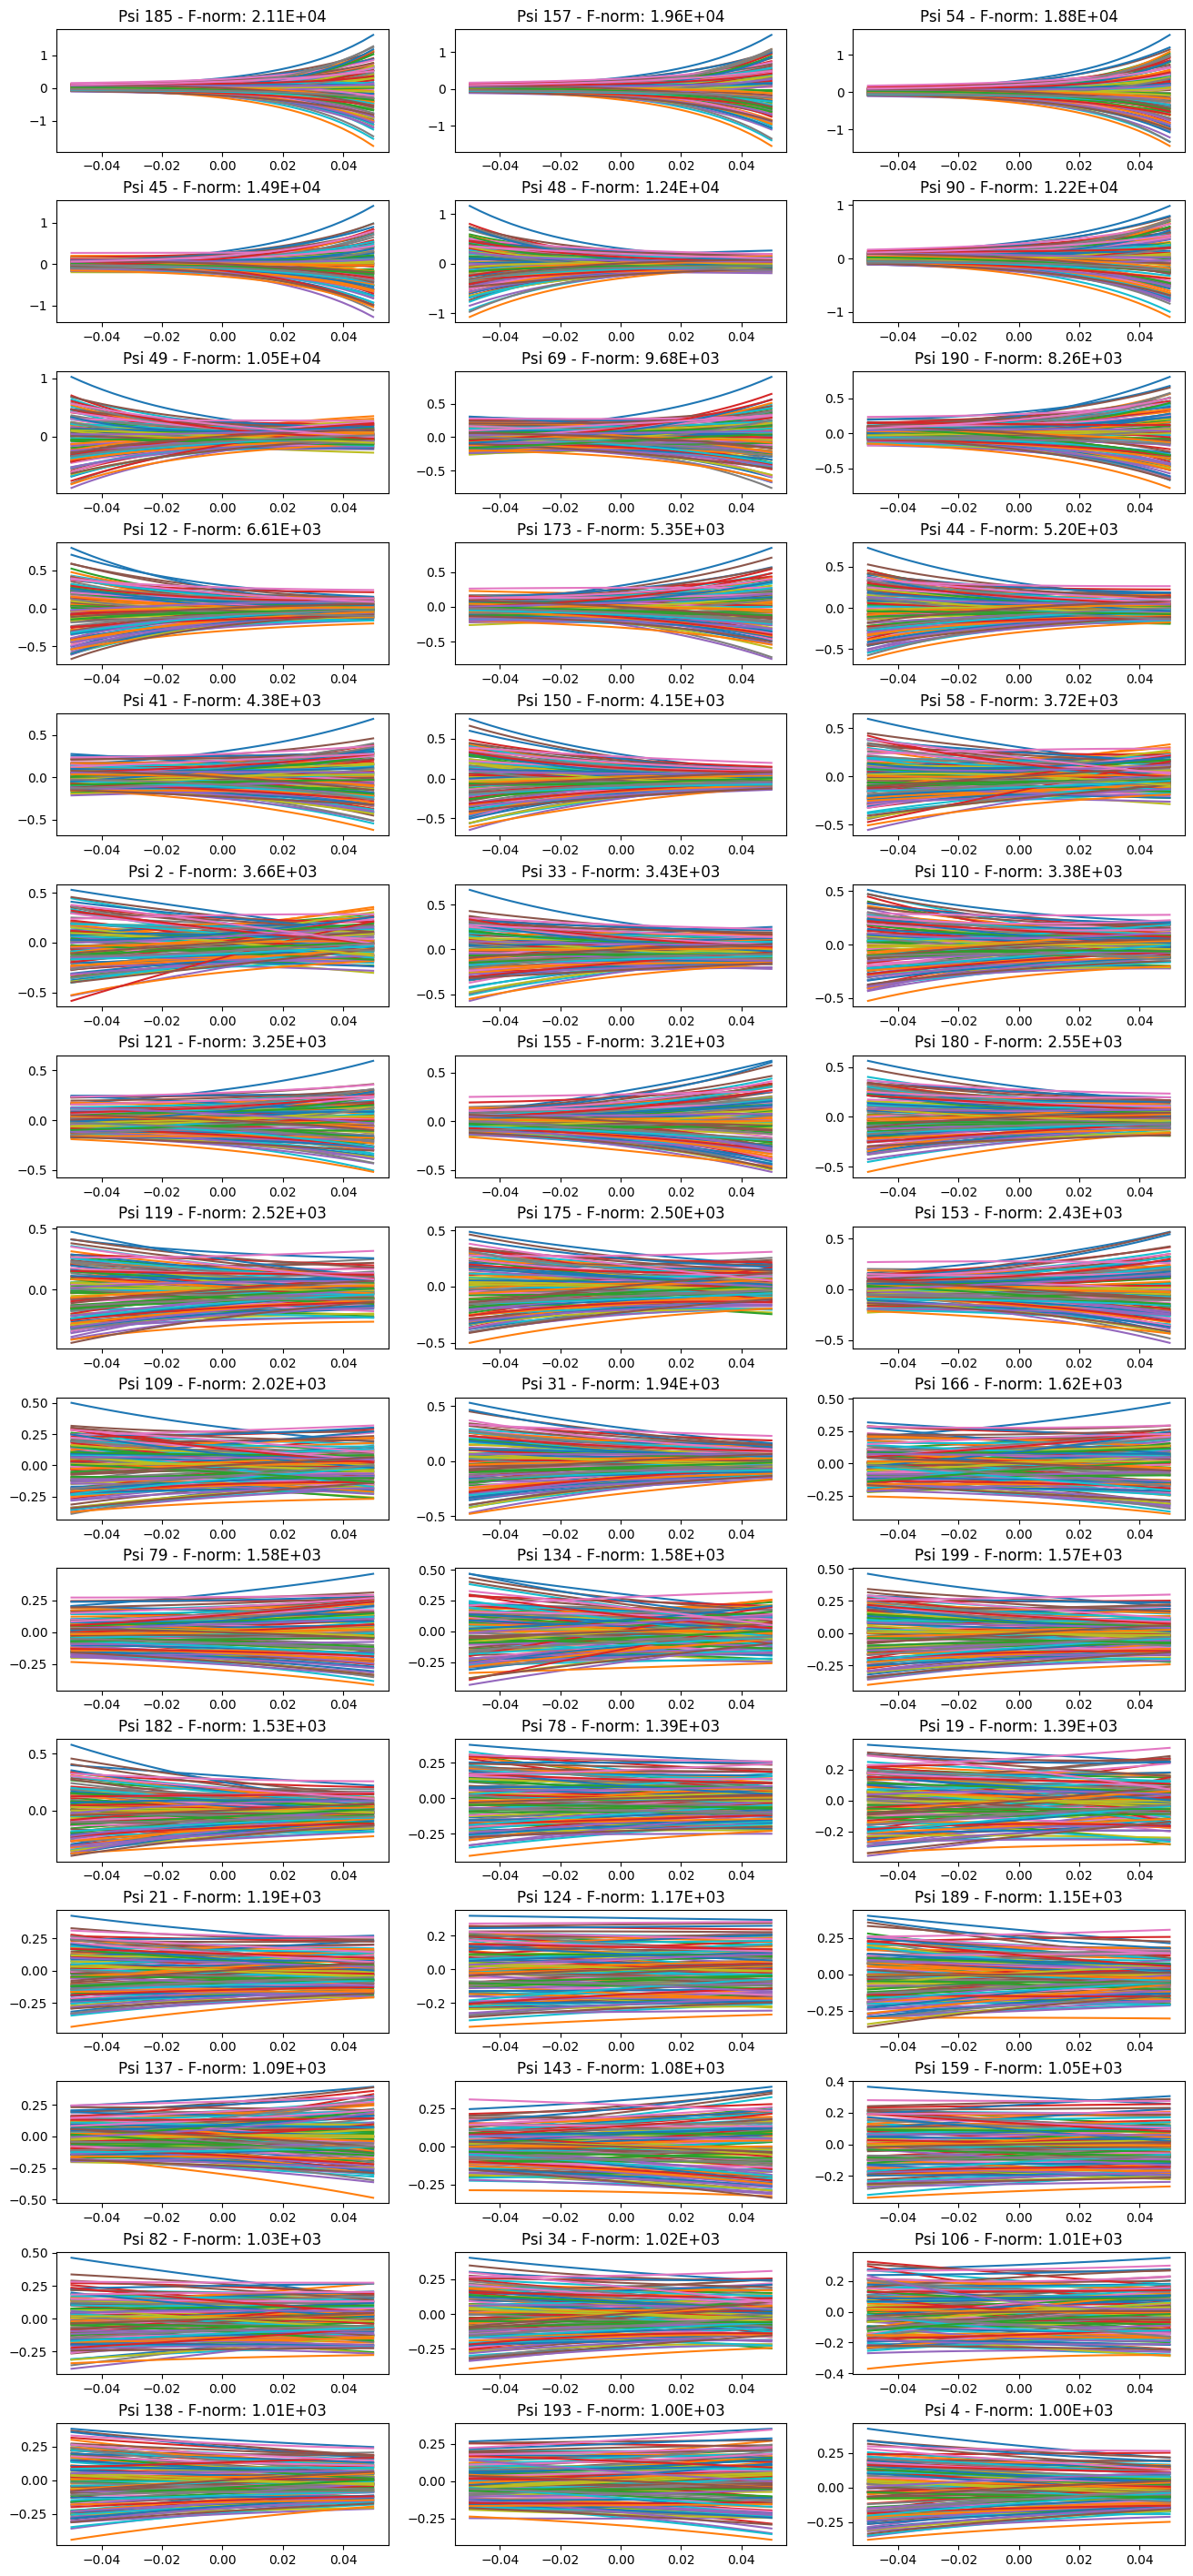

In [7]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

coeff_range = .05
train_example = 5
num_steps = 30

#z = model.backbone(x_gpu[0])[0]
#z = torch.tensor(z0[0][0]).to(default_device)
#psi = model.contrastive_header.transop_header.transop.psi
psi_norm = (psi.reshape(len(psi), -1)**2).sum(dim=-1)
psi_idx = torch.argsort(psi_norm)
latent_dim = len(z)


fig, ax = plt.subplots(nrows=15, ncols=3, figsize=(16, 35))
plt.subplots_adjust(hspace=0.4, top=.9)

for i in range(ax.size):
    row = int(i / 3)
    column = int(i % 3)
    curr_psi = psi_idx[-(i + 1)]
    
    coeff = torch.linspace(-coeff_range, coeff_range, num_steps).to(default_device)
    T = torch.matrix_exp(coeff[:, None, None] * psi[None, curr_psi])
    z1_hat = (T @ z).squeeze(dim=-1)
    
    for z_dim in range(latent_dim):
        ax[row, column].plot(np.linspace(-coeff_range, coeff_range, num_steps), 
                             z1_hat[:, z_dim].detach().cpu().numpy())
    ax[row, column].title.set_text(f'Psi {curr_psi} - F-norm: {psi_norm[curr_psi]:.2E}')
    
#fig.suptitle("Latent Dim Path for Coefficient Sweep from (-{}, {})    Z={}".format(coeff_range, coeff_range, latent_dim))    
print()

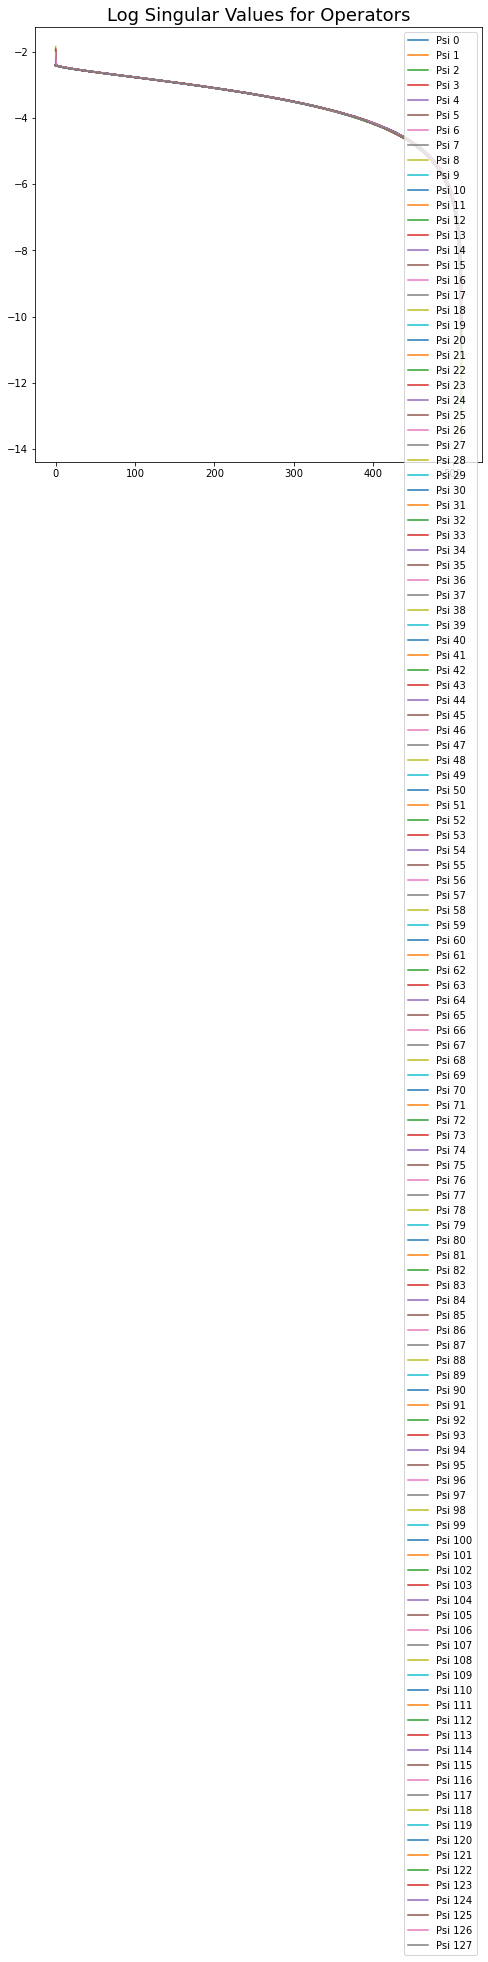

In [12]:
plt.figure(figsize=(8,8))
for idx, operator in enumerate(psi):
    u, s, vt = np.linalg.svd(operator.detach().cpu().numpy())
    plt.plot(np.log(s), label=f"Psi {idx}")
plt.title("Log Singular Values for Operators", fontsize=18)
plt.legend()

Text(0.5, 1.0, 'Real (solid) and Imaginary (dashed)\n Eigenvalues for Operators')

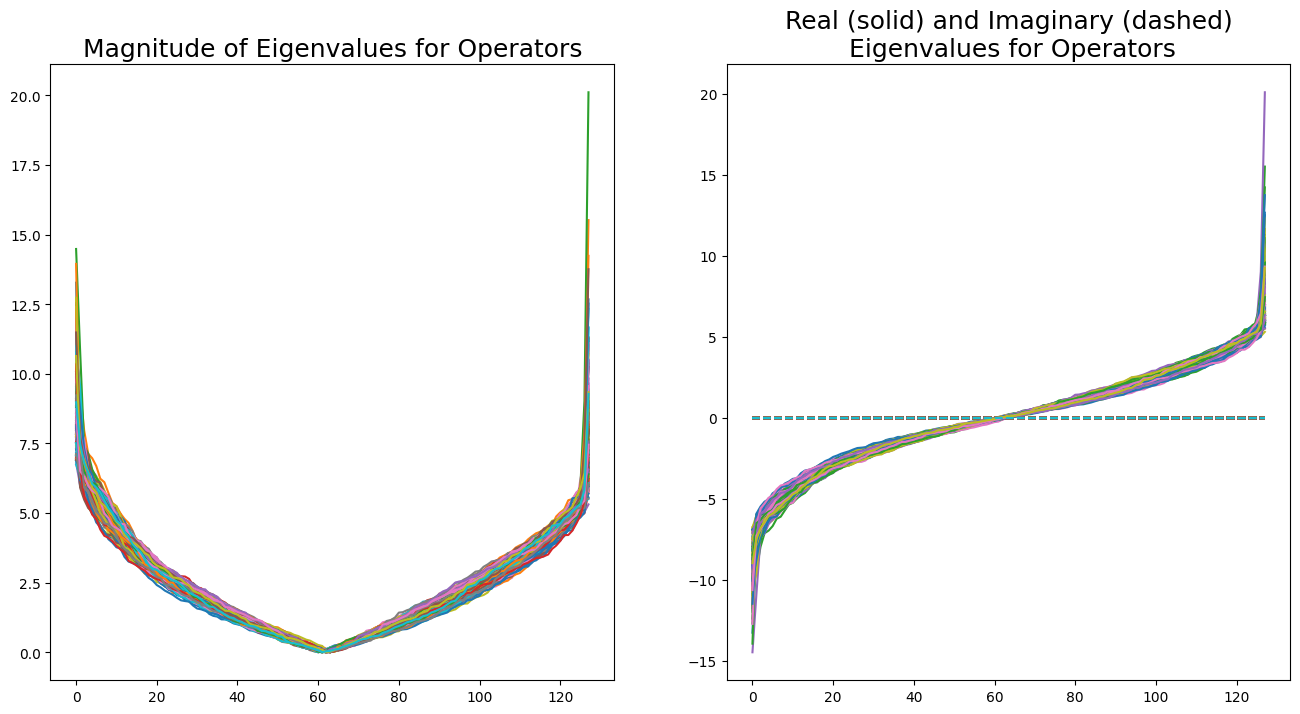

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for operator in psi:
    w, v = np.linalg.eigh(operator.detach().cpu().numpy())
    ax[0].plot(np.absolute(w))
    
    ax[1].plot(w.real)
    ax[1].plot(w.imag, linestyle='--')
ax[0].set_title("Magnitude of Eigenvalues for Operators", fontsize=18)
ax[1].set_title("Real (solid) and Imaginary (dashed)\n Eigenvalues for Operators", fontsize=18)


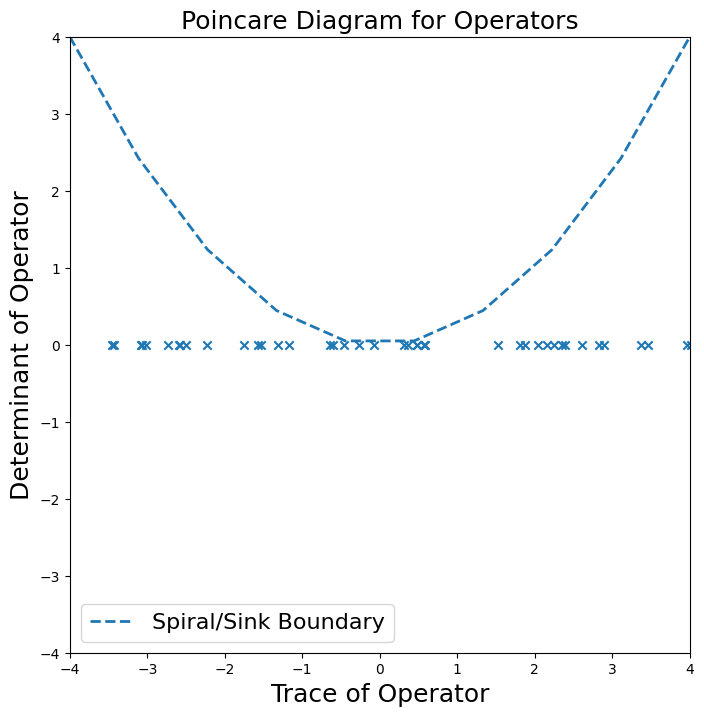

In [8]:
scale = 4

parabola_x = np.linspace(-1 * scale, 1 * scale, 10)
parabola_y = 0.25 * (parabola_x ** 2)

plt.figure(figsize=(8,8))
trace = np.trace(psi.detach().cpu().numpy(), axis1=1, axis2=2)
det = np.linalg.det(psi.detach().cpu().numpy())

plt.scatter(trace, det, marker="x")
plt.plot(parabola_x, parabola_y, label="Spiral/Sink Boundary", linestyle='--', linewidth=2)
plt.xlabel("Trace of Operator", fontsize=18)
plt.ylabel("Determinant of Operator", fontsize=18)
plt.title("Poincare Diagram for Operators", fontsize=18)
plt.xlim([-1 * scale, 1 * scale])
plt.ylim([-1 * scale, 1 * scale])
plt.legend(fontsize=16)

Text(0, 0.5, 'Angle (Degrees)')

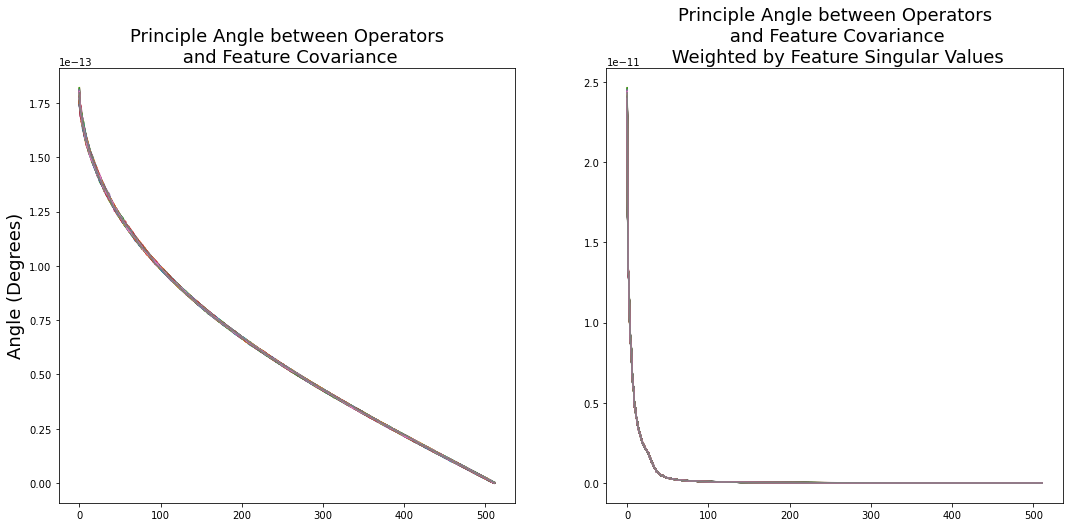

In [11]:
from scipy.linalg import subspace_angles

z = np.concatenate(z0)
z_cov = np.cov(z.T)
u_z, s_z, vt_z = np.linalg.svd(z_cov)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

for operator in psi:
    u, s, vt = np.linalg.svd(operator.detach().cpu().numpy())
    sangles = np.rad2deg(subspace_angles(vt_z, vt))
    ax[0].plot(sangles)
    ax[1].plot(sangles * s_z)
ax[0].set_title("Principle Angle between Operators\n and Feature Covariance", fontsize=18)
ax[1].set_title("Principle Angle between Operators\n and Feature Covariance\n Weighted by Feature Singular Values", fontsize=18)
ax[0].set_ylabel("Angle (Degrees)", fontsize=18)

# Comparing Efficacy of Inference

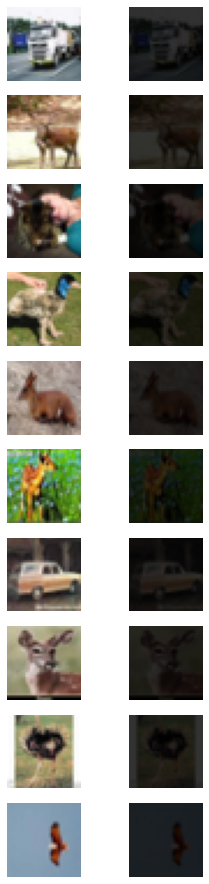

In [5]:
from PIL import Image
import torchvision.transforms.functional as F

start_idx = 1000
num_images = 10
num_samples = 20
transform = lambda x: F.adjust_brightness(x, 0.2)
#transform = lambda x: F.adjust_contrast(x, 0.2)

fig, ax = plt.subplots(nrows=num_images, ncols=2, figsize=(4, 16))
x0 = unaugmented_train_dataloader.dataset.dataset.data[start_idx:start_idx + num_images]
x1 = []
for idx, x in enumerate(x0):
    x_tilde = transform(Image.fromarray(x))
    x1.append(F.to_tensor(x_tilde))

    ax[idx, 0].imshow(x)
    ax[idx, 1].imshow(x_tilde)
[axi.set_axis_off() for axi in ax.ravel()]
x1 = torch.stack(x1)

x = torch.stack([torch.tensor(x0).permute(0, 3, 1, 2), x1], dim=1).to(default_device)
x_idx = torch.arange(start_idx, start_idx + num_images)

c_list = []
model.contrastive_header.transop_header.transop_cfg.total_variational_samples = 40
for j in range(num_samples):
    model_out = model(x, x_idx)
    c_list.append(model_out.distribution_data.samples.detach().cpu())
c_list = torch.stack(c_list)

c0 = c_list
#c1 = c_list

/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


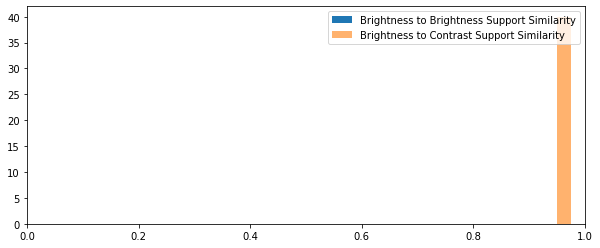

In [6]:
c0_use = c0
c1_use = c1
j00_label = "Brightness to Brightness Support Similarity"
j01_label = "Brightness to Contrast Support Similarity"

def jaccard_sim(tensor0, tensor1):
    t0_supp = set(np.nonzero(tensor0)[0])
    t1_supp = set(np.nonzero(tensor1)[0])
    if len(t0_supp.union(t1_supp)) > 0:
        return len(t0_supp.intersection(t1_supp)) / len(t0_supp.union(t1_supp))    
    else:
        return 0

plt.figure(figsize=(10,4))
jaccard_00 = []
jaccard_01 = []

for j in range(num_images):
    for k in range(j + 1, num_images):
        j00, j01 = 0, 0
        for i in range(num_samples):
            j00 += jaccard_sim(c0_use[i, j].numpy(), c0_use[i, k].numpy())
            j01 += jaccard_sim(c0_use[i, j].numpy(), c1_use[i, k].numpy())
        jaccard_00.append(j00 / num_samples)
        jaccard_01.append(j01 / num_samples)
bins = np.arange(0, 1, 0.025)
plt.hist(jaccard_00, bins=bins, density=True, label=j00_label)
plt.hist(jaccard_01, bins=bins, density=True, label=j01_label, alpha=0.6)
plt.xlim([0, 1])
plt.legend()